In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import soundfile
from sklearn.metrics import confusion_matrix, classification_report
import random
from glob import glob
from tqdm import tqdm

import librosa.effects as le
from tensorflow.image import resize
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import joblib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

2025-05-06 01:29:24.306526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 01:29:24.307142: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 01:29:24.310605: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 01:29:24.320508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746512964.335263   23689 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746512964.33

In [2]:
DATA_PATH = '/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/src/Emotions'

In [3]:
import random

def extract_feature(file_name, mfcc=True, chroma=True, mel=True, augment=False):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if augment:
            if random.random() < 0.5:
                noise = 0.005 * np.random.randn(len(X))
                X = X + noise
            if random.random() < 0.5:
                X = librosa.effects.pitch_shift(X, sr=sample_rate, n_steps=random.choice([-2, 2]))

        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))

    return result

def load_data(data_path=DATA_PATH, test_size=0.2):
    x, y = [], []
    for emotion_label in os.listdir(data_path):
        emotion_path = os.path.join(data_path, emotion_label)
        if not os.path.isdir(emotion_path):
            continue
        for file in os.listdir(emotion_path):
            if not file.lower().endswith(".wav"):
                continue
            file_path = os.path.join(emotion_path, file)
            try:
                features = extract_feature(file_path, augment=True)
                x.append(features)
                y.append(emotion_label)
            except Exception as e:
                print(f"❌ Skipping {file_path}: {e}")
    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

x_train, x_test, y_train, y_test = load_data()

❌ Skipping /home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/src/Emotions/Happy/03-01-03-01-02-01-20.wav: operands could not be broadcast together with shapes (166566,2) (166566,) 


/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


❌ Skipping /home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/src/Emotions/Fearful/03-01-06-01-01-02-20.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)


In [4]:

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (400,), (200, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'batch_size': [64, 128, 270],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 400]
}

# Initialize base model
mlp = MLPClassifier(epsilon=1e-08)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model and hyperparameters
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multi

Best parameters found: {'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 400}


In [5]:

y_pred = best_model.predict(x_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Micro-Precision: {precision:.3f}")
print(f"Micro-Recall:    {recall:.3f}")
print(f"Micro-F1 Score:  {f1:.3f}")
print(classification_report(y_test, y_pred))

print("Best Hyperparameters:", grid_search.best_params_)

Micro-Precision: 0.620
Micro-Recall:    0.620
Micro-F1 Score:  0.620
              precision    recall  f1-score   support

        Angr       0.61      0.80      0.69       410
     Fearful       0.56      0.49      0.52       420
       Happy       0.60      0.54      0.57       459
         Sad       0.71      0.67      0.69       421

    accuracy                           0.62      1710
   macro avg       0.62      0.62      0.62      1710
weighted avg       0.62      0.62      0.62      1710

Best Hyperparameters: {'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 400}


In [6]:
# Set audio directory path
base_dir = './Emotions'
emotion_folders = {
    'Angr': 0,
    'Fearful': 1,
    'Happy': 2,
    'Sad': 3
}

target_shape = (128, 128)

def augment_audio(y, sr):
    if random.random() < 0.5:
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=random.choice([-2, -1, 1, 2]))
    if random.random() < 0.5:
        y += 0.005 * np.random.randn(len(y))
    return y
# Load and process all audio files
X = []
y = []

print("Extracting features...")
for emotion_name, label in emotion_folders.items():
    files = sorted(glob(os.path.join(base_dir, emotion_name, '*.wav')))
    with tqdm(total=len(files), desc=emotion_name) as pbar:
        for file_path in files:
            try:
                audio, sr = librosa.load(file_path, sr=None)
                audio = augment_audio(audio, sr)
                audio = le.time_stretch(audio, rate=1.0)
                mel = librosa.feature.melspectrogram(y=audio, sr=sr)
                mel = resize(np.expand_dims(mel, axis=-1), target_shape)
                X.append(mel)
                y.append(label)
            except Exception as e:
                print(f"Error with {file_path}: {e}")
            pbar.update(1)

# Shuffle
combined = list(zip(X, y))
random.shuffle(combined)
X, y = zip(*combined)


# Convert to arrays
y = to_categorical(y, num_classes=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = tf.stack(X_train)
X_test = tf.stack(X_test)
y_train = tf.stack(y_train)
y_test = tf.stack(y_test)

# Class weights to combat imbalance
y_train_int = np.argmax(y_train.numpy(), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))


# Build CNN model
input_shape = X_train.shape[1:]
input_layer = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Extracting features...


Sad: 100%|██████████| 2167/2167 [02:31<00:00, 14.31it/s]


In [7]:
# Train the model
print("Training model...")
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy[1]:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

Training model...
Epoch 1/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3670 - loss: 2.9225 - val_accuracy: 0.4970 - val_loss: 1.3247
Epoch 2/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5103 - loss: 1.1541 - val_accuracy: 0.5517 - val_loss: 1.1684
Epoch 3/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.5753 - loss: 1.0291 - val_accuracy: 0.5788 - val_loss: 1.1883
Epoch 4/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6112 - loss: 1.0186 - val_accuracy: 0.5877 - val_loss: 1.1727
Epoch 5/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6128 - loss: 0.9324 - val_accuracy: 0.5601 - val_loss: 1.1791
Epoch 6/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6201 - loss: 0.9151 - val_accuracy: 0.5920 - val_loss: 1.1901
Epoch 7/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6481 - loss: 0.8589 - val_accuracy: 0.5826 - val_loss: 1.1491
Epoch 8/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6735 - loss:

In [8]:
y_true = np.argmax(y_test.numpy(), axis=1)  # convert from one-hot to label index

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print(f"Micro-Precision: {precision:.3f}")
print(f"Micro-Recall:    {recall:.3f}")
print(f"Micro-F1 Score:  {f1:.3f}")
print(classification_report(y_true, y_pred, target_names=['Angry', 'Fearful', 'Happy', 'Sad']))

Micro-Precision: 0.581
Micro-Recall:    0.581
Micro-F1 Score:  0.581
              precision    recall  f1-score   support

       Angry       0.65      0.55      0.60       574
     Fearful       0.55      0.40      0.46       481
       Happy       0.48      0.60      0.53       539
         Sad       0.65      0.76      0.70       543

    accuracy                           0.58      2137
   macro avg       0.58      0.58      0.57      2137
weighted avg       0.58      0.58      0.58      2137



In [9]:


def extract_feature(file_name, mfcc=True, chroma=True, mel=True, augment=False):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if augment:
            if random.random() < 0.5:
                noise = 0.005 * np.random.randn(len(X))
                X = X + noise
            if random.random() < 0.5:
                X = librosa.effects.pitch_shift(X, sr=sample_rate, n_steps=random.choice([-2, 2]))

        result = np.array([])

        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_feat))
        if mel:
            mel_feat = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_feat))

    return result


In [10]:
def load_data(data_path=DATA_PATH, test_size=0.2):
    x, y = [], []
    for emotion_label in os.listdir(data_path):
        emotion_path = os.path.join(data_path, emotion_label)
        if not os.path.isdir(emotion_path):
            continue
        for file in os.listdir(emotion_path):
            if not file.lower().endswith(".wav"):
                continue
            file_path = os.path.join(emotion_path, file)
            try:
                features = extract_feature(file_path, augment=True)
                x.append(features)
                y.append(emotion_label)
            except Exception as e:
                print(f"❌ Skipping {file_path}: {e}")
    return train_test_split(np.array(x), y, test_size=test_size, random_state=42)

x_train, x_test, y_train, y_test = load_data()

# Define parameter grid
param_grid = {
    'n_neighbors': [3, 4, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Base model
knn = KNeighborsClassifier()

# Grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model
best_knn = grid_search.best_estimator_

❌ Skipping /home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/src/Emotions/Happy/03-01-03-01-02-01-20.wav: operands could not be broadcast together with shapes (166566,2) (166566,) 
❌ Skipping /home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/src/Emotions/Fearful/03-01-06-01-01-02-20.wav: operands could not be broadcast together with shapes (209809,2) (209809,) 


/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/verethragna/Documents/itmd-524/Audio-Emotion-Classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partia

In [11]:
y_pred=best_knn.predict(x_test)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Micro-Precision: {precision:.3f}")
print(f"Micro-Recall:    {recall:.3f}")
print(f"Micro-F1 Score:  {f1:.3f}")
print(classification_report(y_test, y_pred))

print("Best Hyperparameters:", grid_search.best_params_)

Micro-Precision: 0.625
Micro-Recall:    0.625
Micro-F1 Score:  0.625
              precision    recall  f1-score   support

        Angr       0.68      0.69      0.68       410
     Fearful       0.57      0.42      0.49       420
       Happy       0.60      0.60      0.60       459
         Sad       0.63      0.79      0.70       421

    accuracy                           0.62      1710
   macro avg       0.62      0.63      0.62      1710
weighted avg       0.62      0.62      0.62      1710

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


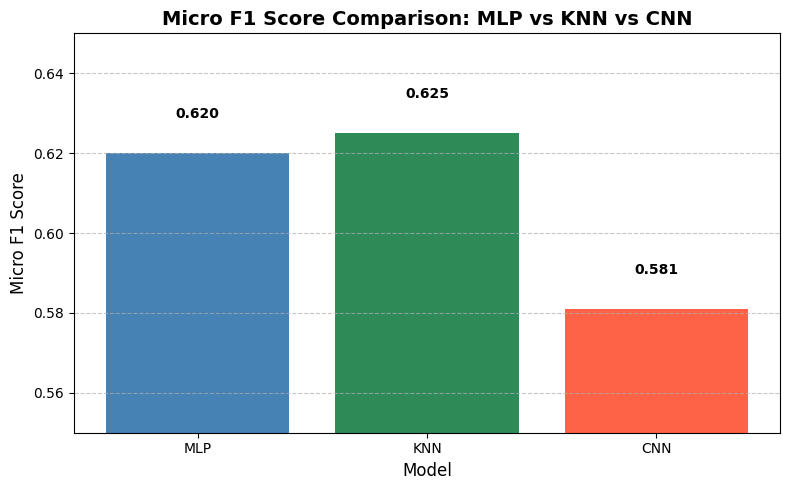

In [13]:
import matplotlib.pyplot as plt

# Model names and scores
models = ['MLP', 'KNN', 'CNN']
scores = [0.620, 0.625, 0.581]
colors = ['steelblue', 'seagreen', 'tomato']  # distinct colors

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=colors)

# Add score labels on top of bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.008, f"{score:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart aesthetics
plt.title("Micro F1 Score Comparison: MLP vs KNN vs CNN", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Micro F1 Score", fontsize=12)
plt.ylim(0.55, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
